\section{Kitaev Hamiltonian}

\begin{equation}
    H_K = - \sum_{<j,k>_\alpha} J_\alpha S_j^\alpha S_k^\alpha
\end{equation}
where $\alpha = x, y, z$.

\subsection{Energy spectrum of Kitaev Hamiltonian}

\qquad  The ground state (GS) of Kitaev model can be exactly solved by representing the spin operators by Majorana operators: $\sigma_j^\alpha = ic_j b_j^\alpha$. The Hamiltonain becomes:

\begin{equation}
    H_{Maj} = \sum_{<j,k>_\alpha} \frac{J_\alpha}{4} (i b_j^\alpha b_k^\alpha ) \ i  c_j c_k 
            = \sum_{<j,k>_\alpha} \frac{J_\alpha}{4} u_{<j,k>_\alpha} \ i c_j c_k
\end{equation}

where $u_{<j,k>_\alpha} = i b_j^\alpha b_k^\alpha$. There also be a constrain $i c_j b_j^x b_j^y b_j^z = 1$ applied to limit the system to the physical Hilbert space. It has been proved that all $u_{<j,k>_\alpha} = 1$ in the ground state. Thus the Hamiltonian becomes quadratic and the energy spectrum can be solved by Fourier transformation. The GS energy spectrum is:

\begin{align}
    E(\vec{k}) &= \pm |f(\vec{k})| \\
    f(\vec{k}) &= \frac{1}{2} (J_x e^{i k_1} + J_y e^{i k_2} + J_z )
\end{align}

where $k_1$ and $k_2$ are the components of $\vec{k}$ along $\vec{n}_1$ and $\vec{n}_2$ directions.


\subsection{Ground state energy of a finite lattice}

\qquad  In order to check the correctness of the ED code. Here we give a explicite calculation of the GS energy of Kitaev model on $N_1 \times N_2 \times 2$ lattice. The lattice vectors are $\vec{n}_1 = (0,1), \vec{n}_2 = (\frac{1}{2},\frac{\sqrt{3}}{2})$. The number of unit cells along these two directions are $N_1$ and $N_2$ respectively.

\quad The GS Hamiltonian can be written as:

\begin{equation}
    H_{MF} = \sum_{<j,k>_\alpha} \frac{J_\alpha}{4} i  c_j c_k 
\end{equation}

We can explicitly write $H_G$ in real space and diagonalize the Hamiltonian to get its ground state energy. Since the ground state of Kitaev model is four-fold degenerate, we have to change the boundary conditions to find the lowest energy.

\quad  In the following code, the basis we use is $(c_{1A},\ c_{1B},\ ... \,\ c_{NA},\ c_{NB})^T$, where $N = N_1 \times N_2$ is the number of lattice sites. We label each unit cell by its row and colume numbers $(r, c)$ (start from $0$), the label of this unit cell given by $ n = r \times N_1 + c$. We can label A atom in the $n$-th unit cell as $2n$ and B atom as $2n + 1$.

In [20]:
import numpy as np
from numpy.linalg import eigvalsh
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import eigsh

def index(N1, N2, c, r, atom = 'A'):
    '''Calculate the index of the atoms in the (r,c) unit cell'''
    c = c % N1
    r = r % N2
    
    n = r * N1 + c
    if atom == 'A':
        ind = 2 * n
    elif atom == 'B':
        ind = 2 * n + 1
    else:
        return print('ERROR: The atom index should be A or B.')
    return ind

def MajHam_csc(JK, N1, N2, xdir = 'P', ydir = 'P'):
    '''Kitaev Hamiltonian in fixed flux pattern
    
       Inputs: JK : 1*3 matrix, Jx=J[0], Jy = J[1], Jz=J[2]
               N1,N2: int
               row: periodic (P) or anti-periodic (A) boundary condition, or open boundary (O)
               
       Return: positions and values of non-zero elements of HK^0'''
    
    SiteNum = N1 * N2 * 2
    JK = JK / 4
    
    col = []
    row = []
    data = []
    for r in range(N2):
        for c in range(N1):
            temp = {} # A temporary dict
            ind = index(N1, N2, c, r, atom = 'A')  #label of unit cell
            '''X-bonds'''
            next = index(N1, N2, c, r, atom = 'B')
            if next in temp:
                temp[next] += 1j * JK[0]
            else: 
                temp[next] = 1j * JK[0]
                
            '''Y-bonds'''
            if xdir == 'O' and c == 0:
                pass
            else:
                next = index(N1, N2, c - 1, r, atom = 'B')
                
                if next in temp:
                    if xdir == 'A' and c == 0:
                        temp[next] -= 1j * JK[1]
                    else:
                        temp[next] += 1j * JK[1]
                else:
                    if xdir == 'A' and c == 0:
                        temp[next] = - 1j * JK[1]
                    else:
                        temp[next] =  1j * JK[1]
                        
            '''Z-bonds'''
            if ydir == 'O' and r == 0:
                pass
            else:
                next = index(N1, N2, c, r-1, atom = 'B')
                
                if next in temp:
                    if ydir == 'A' and r == 0:
                        temp[next] -= 1j * JK[2]
                    else:
                        temp[next] += 1j * JK[2]
                else:
                    if ydir == 'A' and r == 0:
                        temp[next] = - 1j * JK[2]
                    else:
                        temp[next] =  1j * JK[2]          

            odTemp = sorted(temp)
            for e in odTemp:
                col.append(ind)
                row.append(e)
                data.append(temp[e])                   
    return col, row, data

def makeH(col, row, data, dim):
    '''Make csc format Hamiltonian
       
       Inputs : row,col :position of the non-zero elementds of Hamiltonian matrix
                data: H(row,col) = data
                dim: Hamiltonian matrix dimension
       Return: Hcsc: csc formate Hamiltonian
       
       Notice: we only have to enter half of the elements and get the other half 
               by hermition conjugate.'''
    Hcsc = csc_matrix((data, (row, col)), shape=(dim, dim),dtype = complex)
    Hcsc = (Hcsc + Hcsc.getH()) /2 
    return Hcsc


N1 = 2
N2 = 3
SiteNum = N1 * N2 * 2

JK = 1 * np.ones(3)

e = np.zeros([SiteNum,4])
GSenergy = np.zeros(4)
H = {} # Hamiltonian dict

col =[]
row = []
data = []
col, row, data = MajHam_csc(JK, N1, N2, xdir = 'P', ydir = 'P')
Hr = makeH(col, row, data, SiteNum)
H[0] = Hr.toarray()

        
col1 =[]
row1 = []
data1= []
col1, row1, data1 = MajHam_csc(JK, N1, N2, xdir = 'P', ydir = 'A')
Hr1 = makeH(col1, row1, data1, SiteNum)
H[1] = Hr1.toarray()


col2 =[]
row2 = []
data2 = []
col2, row2, data2 = MajHam_csc(JK, N1, N2, xdir = 'A', ydir = 'P')
Hr2 = makeH(col2, row2, data2, SiteNum)
H[2] = Hr2.toarray()

col3 =[]
row3 = []
data3 = []
col3, row3, data3 = MajHam_csc(JK, N1, N2, xdir = 'A', ydir = 'A')
Hr3 = makeH(col3, row3, data3, SiteNum)
H[3] = Hr3.toarray()

for i in range(4):
    e[:,i] = eigvalsh( H[i] * 2 )
    for j in e[:,i]:
        if j < 0:
            GSenergy[i] += j
            
print(min(GSenergy)/ SiteNum)

col4 =[]
row4 = []
data4 = []
col4, row4, data4 = MajHam_csc(JK, N1, N2, xdir = 'O', ydir = 'O')
Hr4 = makeH(col4, row4, data4, SiteNum)
H4 = Hr4.toarray()

val = eigvalsh(H4 * 2)
sum = 0
for i in val:
    if i < 0:
        sum += i
print(sum / SiteNum)

-0.20417255625506472
-0.16119721896187558


\section{Basis generation}

\quad We use the eigen states of course we $S^z$ as basis states and use $|0 \rangle$ to represent $|\downarrow \rangle$ and $|1 \rangle$ to represent $|\uparrow \rangle$. The states can thus be represented by a set of binary numbers. Moreover, we can use the corresponding dicimal number of each state as its tag.

\quad For a system with N sites, the dimension of Hilbert space is $2^N$.

\section{Hamiltonian matrix}

\quad The Hamiltonian can be rewriten to $H_K = H_x + H_y +H_z$, where $H_z$ is the diagonal term and $H_x, H_y$ are off-diagonal terms:
\begin{align}
      H_x &= -\sum_{<i,j>_x} J_x S_i^x S_j^x = -\sum_{<i,j>_x} \frac{J_x}{4} ( S_i^+ S_j^- + S_i^- S_j^+ + S_i^+ S_j^+            + S_i^- S_j^-)\\
      H_y &= -\sum_{<i,j>_y} J_y S_i^y S_j^y = -\sum_{<i,j>_y} \frac{J_y}{4} ( S_i^+ S_j^- + S_i^- S_j^+ - S_i^+ S_j^+            - S_i^- S_j^-)\\
      H_z &= -\sum_{<i,j>_z} J_z S_i^z S_j^z
\end{align}
where $S_i^\pm = S_i^x \pm i S_i^y$.

\subsection{$ N_1 \times N_2 \times 2$ lattice}

\quad The lattice vectors are $\vec{n}_1 = (0,1), \vec{n}_2 = (\frac{1}{2},\frac{\sqrt{3}}{2})$. The number of unit cells along these two directions are $N_1$ and $N_2$ respectively. We label each unit cell by its row and colume numbers $(r, c)$(start from $0$), the label of this unit cell given by $ n = r \times N_1 + c$. We can label A atom in the $n$-th unit cell as $2n$ and B atom as $2n + 1$.

\quad For reference, the ground state energies of Kitaev model with different lattice sizes are (PBC):

| N1 | N2 | GS energy |
|---|---|---|
|2  | 3 | -0.204172555  |
|2  | 4 | -0.2022542475 |
|3  | 3 | -0.19849309   |
|3  | 4 | -0.198872775  |
|2  | 6 | -0.2003512    |


In [21]:
import numpy as np
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import eigsh

def StateConfig(tag):
    '''The configuration of the state with tag.
    
       Setups required: 
           dim: Hilbert space dimension
           SiteNum: total site number
           
       Return: binary form of tag. type: list'''
    if tag >= dim:
        return print('Error: The tag is out of range.')
    else:
        b = bin(tag)[2:]
        b = b.rjust(SiteNum,'0') 
        return b

def flip(tag,i,j):
    '''Flip the spin on i,j site.
    
       Setups required: 
           SiteNum: total site number
           
       Return: The tag of new state, type: int '''
    f = pow(2, SiteNum - i -1) + pow(2, SiteNum - j -1)
    Newtag = tag^f
    return Newtag

def index(N1, N2, c, r, atom = 'A'):
    '''Calculate the index of the atoms in the (r,c) unit cell'''
    c = c % N1
    r = r % N2
    
    n = r * N1 + c
    if atom == 'A':
        ind = 2 * n
    elif atom == 'B':
        ind = 2 * n + 1
    else:
        return print('ERROR: The atom index should be A or B.')
    return ind

def KitaevRhom(J, N1, N2, periodic = True):
    '''Kitaev Hamiltonian on N1 * N2 * 2 lattice
       N1: number of unit cells in n1-direction, column number
       N2: number of unit cells in n1-direction, row number
    
       Inputes: 
           N1, N2: width and length of the rhomboid cluster
           SiteNum: total site number
           dim: Hilbert space dimension
        
        Return: The Non-zero Hamiltonian element H[i] is in the 
                position (row[i], col[i])
                H, row, col : type: list
        '''
    SiteNum = N1 * N2 * 2
    dim = pow(2, SiteNum)
    
    numNZero = 0 # count the number of non-zero element
    data = []
    row = []
    col = []
    for tag in range(dim):
        #print('The state numnber is: ', tag)
        si = StateConfig(tag) # initial state configuration
        #print('initial configuration=',si,', tag = ',tag)
        
        temp = {} # A temporay dict
        
        for r in range(N2):
            for c in range(N1):
                ind = index(N1, N2, c, r, atom = 'A')
                
                '''Sx Sx'''
                next = index(N1, N2, c, r, atom = 'B')
                
                ntag = flip(tag, ind, next)
                if ntag in temp:
                    temp[ntag] += -J[0] /4
                else:
                    temp[ntag] = -J[0] /4
                                
                '''Sy Sy'''
                if periodic == False and c == 0:
                    pass
                else:
                    next = index(N1, N2, c - 1, r, atom = 'B')
                    
                    ntag = flip(tag, ind, next)
                    if ntag in temp:
                        temp[ntag] += J[1] * (int(si[ind]) - 0.5) * (int(si[next]) - 0.5)
                    else:
                        temp[ntag] = J[1] * (int(si[ind]) - 0.5) * (int(si[next]) - 0.5)
                        

                '''Sz Sz'''
                if periodic == False and r == 0:
                    pass
                else:
                    next = index(N1, N2, c, r - 1, atom = 'B')
                    
                    if tag in temp:
                        temp[tag] += - J[2] * (int(si[ind]) - 0.5) * (int(si[next]) - 0.5)
                    else:
                        temp[tag] = - J[2] * (int(si[ind]) - 0.5)* (int(si[next]) - 0.5)
                        
        odTemp = sorted(temp)
        for sf in odTemp:
            col.append (tag)
            row.append (sf)
            data.append (temp[sf])
            numNZero += 1
            
    print ('non zero elemens number = ', numNZero)
    print('Percentage = ', numNZero/(dim * dim) * 100,'%')
    return col, row, data


N1 = 2
N2 = 3
SiteNum = N1 * N2 * 2
dim = pow(2, SiteNum)

J = np.array([1,1,1])
H = []
row = []
col = []

col, row, data = KitaevRhom(J, N1, N2, periodic = True)
#for l in range(len(H)):
    #print('(',row[l],',',col[l],') = ', H[l])

ham = csc_matrix ((data, (row, col)), shape=(dim, dim))
#print(ham)
#vals, vecs = eigsh (ham, k=5, which = 'SA')

#print (vals / SiteNum)

non zero elemens number =  53248
Percentage =  0.3173828125 %


\section{KSL under a uniform magnetic field}

\quad The magnetic field Hamiltonian is:

\begin{equation}
    H_h = - \sum_j \vec{h} \cdot \vec{S_j} = - \sum_{j,\alpha} h_\alpha S_j^\alpha, \ \ \alpha= x, y, z
\end{equation}

Using the relations:
\begin{align}
    S_j^x & = \frac{1}{2}( S_j^- + S_j^+ )\\
    S_j^y & = - \frac{i}{2} (S_j^+ - S_j^- )
\end{align}

In [22]:
def flip1(tag,i):
    '''Flip the spin on i site.
    
       Setups required: 
           SiteNum: total site number
           
       Return: The tag of new state, type: int '''
    f = pow(2, SiteNum - i -1)
    Newtag = tag^f
    return Newtag

def MagHam(h, N1, N2):
    '''CSC formation of the magnetic field Hamiltonian
       Inputs: h: 1 * 3 array, magnetix field
               N1, N2: lattice size
               
       Outputs: Non-zero matrix elements of the magnetic field Hamiltonian'''
    SiteNum = N1 * N2 * 2
    dim = pow(2,SiteNum)

    row = []
    col = []
    data= []
    
    for tag in range(dim):
        si = StateConfig(tag) # initial state
        
        temp = {} # temporary dict
        for i in range(SiteNum):
            '''z-direction'''
            if tag in temp:
                temp[tag] += - h[2] * (int(si[i]) - 0.5)
            else:
                temp[tag] = - h[2] * (int(si[i]) - 0.5)
                
            ntag = flip1(tag, i)
            '''x-direction and y-direction'''
            if ntag in temp:
                temp[ntag] += - h[0] * 0.5 - h[1] * 1j * (int(si[i]) - 0.5)
            else:
                temp[ntag] = - h[0] * 0.5 - h[1] * 1j * (int(si[i]) - 0.5) 
                
        odTemp = sorted(temp)
        for sf in odTemp:
            col.append (tag)
            row.append (sf)
            data.append (temp[sf]) 
    return col, row, data

\quad Now plot the Calculate the GS energy change with respect to the magnetic field.

In [82]:
hmin = 1.e-5
hmax = 1
step = 100
a = np.linspace(hmin, hmax, step)
e = np.zeros([5,step])
e1 = np.zeros([5,step])
v = {}

N1 = 2
N2 = 3

SiteNum = N1 * N2 * 2
dim = pow(2, SiteNum)

J = np.array([4,4,4])
data = []
row = []
col = []

col, row, data = KitaevRhom(J, N1, N2, periodic = True)
del ham
ham = csc_matrix ((data, (row, col)), shape=(dim, dim))

for i in range(step):
    field = np.array([1,1,1]) * 2 * a[i]
    
    #generate magentic field Hamiltonian
    rowf = []
    colf = []
    dataf = []
    colf, rowf, dataf = MagHam(field, N1, N2)
    del magh
    magh = csc_matrix ((dataf, (rowf, colf)), shape=(dim, dim))
    
    del toth
    toth = ham + magh
    #print('check:', toth)
    e[:,i], v[i] = eigsh (toth, k=5, which = 'SA')
    #e1[:,h], v[h] = eigsh (magh, k=5, which = 'SA')
    e[:,i] = e[:,i]/SiteNum
    #e1[:,h] = e1[:,h]/SiteNum

non zero elemens number =  53248
Percentage =  0.3173828125 %


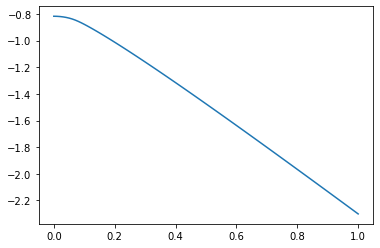

In [83]:
import matplotlib.pyplot as plt

plt.plot(a, e[0,:]) 


\section{Physical quanties}

\subsection{Magnetization}


In [12]:
def flip1(tag,i):
    '''Flip the spin on i site.
    
       Setups required: 
           SiteNum: total site number
           
       Return: The tag of new state, type: int '''
    f = pow(2, SiteNum - i -1)
    Newtag = tag^f
    return Newtag

def magnetization(state, N1, N2):
    '''Average magnetization
       Inputs: state: the state that we are working in
               N1, N2: lattice size
       Outputs: s: 1*4 array, Sx = s[0], Sy = s[1], Sz=s[2], S = s[3]'''
    
    SiteNum = N1 * N2 * 2
    dim = pow(2,SiteNum)
    if dim != len(state):
        return print('ERROR: the state doesn’t match the lattice.')
    else:
        pass
    
    s = np.zeros(4, dtype = complex)
    for tag in range(dim):
        si = StateConfig(tag) # initial state
        for i in range(SiteNum):
            s[2] += (int(si[i]) - 1/2) * np.conj(state[tag]) * state[tag]
            
            ntag = flip1(tag, i)
            s[0] += 1/2 * np.conj(state[ntag]) * state[tag]
            s[1] += 1j * (int(si[i]) - 1/2) * np.conj(state[ntag]) * state[tag] 
         
    for i in range(3):
        s[3] += np.conj(s[i]) * s[i]
    s[3] = np.sqrt(s[3])
    return s / SiteNum



\subsection{Flux on hexagons}

\quad In Kitaev model, the Wilson loop operator of a hexagon is conserved.
\begin{equation}
    \hat{W}_P = \sigma_0^z \sigma_1^y \sigma_2^x \sigma_3^z \sigma_4^y \sigma_5^x
\end{equation}

\quad We label the hexagon by the position of site-$0$. If the position of site-$0$ is $(r,c)$, then:

| 0       | 1       | 2         | 3           | 4           | 5         |
|---      |---      |---        |---          |---          |---        |
| (r,c)-A | (r,c)-B | (r+1,c)-A | (r+1,c-1)-B | (r+1,c-1)-A | (r,c-1)-B |

<img src = hexagon.png width = "200">

\quad Suppose we have a state $|G \rangle$, the expectation value of $\hat{W}_P$ is $W_P = < \hat{W}_P >$:

\begin{equation}
    W_P = \langle G | \hat{W}_P | G \rangle 
        = \sum_j \langle G | \hat{W}_P |\psi_j \rangle \langle \psi_j| G \rangle 
\end{equation}

Using the relations:
\begin{align}
    \sigma_j^x & = S_j^- + S_j^+ \\
    \sigma_j^y & = -i(S_j^+ - S_j^- )
\end{align}

In [93]:
def HexFlux(N1, N2, state, r, c):
    '''Calculate the flux of a specific hexagon.
    
       Inputs: state: eigen-state that we are working on
               r,c : position of the hexagon
    
       Output: Wp'''
    SiteNum = N1 * N2 * 2
    dim = pow(2,SiteNum)
    if dim != len(state):
        return print('ERROR: the state doesn’t match the lattice.')
    else:
        pass
    
    sites = np.zeros(6, dtype = int)
    sites[0] = index(N1, N2, c, r, atom = 'A')
    sites[1] = index(N1, N2, c, r, atom = 'B')
    sites[2] = index(N1, N2, c, r+1, atom = 'A')
    sites[3] = index(N1, N2, c-1, r+1, atom = 'B')
    sites[4] = index(N1, N2, c-1, r+1, atom = 'A')
    sites[5] = index(N1, N2, c-1, r, atom = 'B')
    
    print(sites)
    Wp = 0
    for tag in range(dim):
        si = StateConfig(tag) # initial state
        co = 1 # Coefficient got after appling Wp to si
        
        '''z: collect signs, do not change the state'''
        co *= np.sign(int(si[sites[0]]) - 1/2)
        co *= np.sign(int(si[sites[3]]) - 1/2)
        
        ntag = tag
        
        '''x: flip spins, no extra coefficients'''
        ntag = flip(ntag, sites[2], sites[5])
        
        '''y: flip spins and collect signs'''
        ntag = flip(ntag, sites[1], sites[4])
        
        co *= -1 #(-1j)^2
        co *= np.sign(int(si[sites[1]]) - 1/2)
        co *= np.sign(int(si[sites[4]]) - 1/2)
        
        Wp += co * np.conj(state[ntag]) * state[tag]
    return Wp

In [103]:
def HexFlux2(N1, N2, state, r, c):
    '''Calculate the flux of a specific hexagon.
    
       Inputs: state: eigen-state that we are working on
               r,c : position of the hexagon
    
       Output: Wp'''
    SiteNum = N1 * N2 * 2
    dim = pow(2,SiteNum)
    if dim != len(state):
        return print('ERROR: the state doesn’t match the lattice.')
    else:
        pass
    
    sites = np.zeros(6, dtype = int)
    sites[0] = index(N1, N2, c, r, atom = 'A')
    sites[1] = index(N1, N2, c, r, atom = 'B')
    sites[2] = index(N1, N2, c, r+1, atom = 'A')
    sites[3] = index(N1, N2, c-1, r+1, atom = 'B')
    sites[4] = index(N1, N2, c-1, r+1, atom = 'A')
    sites[5] = index(N1, N2, c-1, r, atom = 'B')
    
    print(sites)
    Wp = 0
    for tag in range(dim):
        si = StateConfig(tag) # initial state
        co = 1 # Coefficient got after appling Wp to si
        
        '''0-1, x-x'''
        ntag = flip(tag, sites[0], sites[1])
        sf = StateConfig(ntag)
        
        '''1-2, z-z'''
        co *= np.sign(int(sf[sites[1]]) - 1/2) * np.sign(int(sf[sites[2]]) - 1/2)
        
        '''2-3, y-y'''
        co *= -1
        co *= np.sign(int(sf[sites[2]]) - 1/2) * np.sign(int(sf[sites[3]]) - 1/2)
    
        ntag = flip(ntag, sites[2], sites[3])
        sf = StateConfig(ntag)
        
        '''3-4, x-x'''
        ntag = flip(ntag, sites[3], sites[4])
        sf = StateConfig(ntag)
        
        '''4-5, z-z'''
        co *= np.sign(int(sf[sites[4]]) - 1/2) * np.sign(int(sf[sites[5]]) - 1/2)   
        
        '''5-0, y-y'''
        co *= -1
        co *= np.sign(int(sf[sites[5]]) - 1/2) * np.sign(int(sf[sites[0]]) - 1/2)
    
        ntag = flip(ntag, sites[5], sites[0])
        sf = StateConfig(ntag)
        
        Wp += co * np.conj(state[ntag]) * state[tag]
    return Wp